**Use Resnet 50+ Cutmix along with ring loss** 

In [1]:
!nvidia-smi

Tue Aug 11 10:49:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   27C    P8    35W / 280W |    882MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 41%   32C    P8    22W / 280W |     11MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms, datasets, models
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**Dataloading Scheme**

In [4]:
trainlist = 'new_classification_lists/new_classification_trainlist.txt'
validlist ='new_classification_lists/new_classification_vallist.txt'


In [5]:
# Create a mapping of Unique product Ids to Labels(0 to 3713 classes)
# output = dictionary containing mapping of each upc to a label from (0 to 3713)  

with open(trainlist, mode = 'r') as f:
    
    Y=[]
    for line in f:
        path, UPC = line[:-1].split(',')

        Y.append(UPC)
        
prime_number_list = sorted(set(Y))

prime_number_dict = { prime_number_list[i] :i for i in range(0, len(prime_number_list) ) }

In [6]:
len(prime_number_dict)

31128

In [7]:
class mydataset():    

    def __init__(self, classification_list, prime_number_dict, name):

        super(mydataset).__init__()
        
        self.X = []
        self.Y = []
        
        with open(classification_list, mode = 'r') as f:
            
            for line in f:
                path, Prime_Number = line[:-1].split(',')

                self.X.append(path)
                self.Y.append(prime_number_dict[Prime_Number])
        

        if name == 'valid':
            self.transform = transforms.Compose([   transforms.RandomResizedCrop((224)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                ])
        else:
            self.transform = transforms.Compose([   transforms.RandomResizedCrop((224)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                                                                            ])
    
    def __getitem__(self,index):
        
        image = self.X[index]        
        label = float(self.Y[index])
        
        image = (Image.open(image))
               
        image = self.transform(image)
        
        return image, torch.as_tensor(label).long()
        
  
    def __len__(self):
        return len(self.X)

In [8]:
# # #### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_number_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 512, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_number_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=True, batch_size = 256, num_workers=16,pin_memory=True)

**RESNET Architecture**

**Model Definition**

In [9]:
import torch.nn as nn
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * Bottleneck.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, depth, num_classes, bottleneck=False):
        super(ResNet, self).__init__()        
        
        
        blocks ={18: BasicBlock, 34: BasicBlock, 50: Bottleneck, 101: Bottleneck, 152: Bottleneck, 200: Bottleneck}
        layers ={18: [2, 2, 2, 2], 34: [3, 4, 6, 3], 50: [3, 4, 6, 3], 101: [3, 4, 23, 3], 152: [3, 8, 36, 3], 200: [3, 24, 36, 3]}
        assert layers[depth], 'invalid detph for ResNet (depth should be one of 18, 34, 50, 101, 152, and 200)'

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(blocks[depth], 64, layers[depth][0])
        self.layer2 = self._make_layer(blocks[depth], 128, layers[depth][1], stride=2)
        self.layer3 = self._make_layer(blocks[depth], 256, layers[depth][2], stride=2)
        self.layer4 = self._make_layer(blocks[depth], 512, layers[depth][3], stride=2)
        self.avgpool = nn.AvgPool2d(7) 
        self.fc = nn.Linear(512 * blocks[depth].expansion, num_classes)
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            
            ## ResNet-D modification, add Average pool before conv in Path-b of Downsampling block; change stride of conv to 1
            if stride == 1:
                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                     kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )
            else:
                downsample = nn.Sequential(
                    nn.AvgPool2d(stride),
                    nn.Conv2d(self.inplanes, planes * block.expansion,
                     kernel_size=1, stride=1, bias=False),
                    nn.BatchNorm2d(planes * block.expansion),
                )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        
        return x


**Initialize the model**

In [10]:
model = ResNet(depth = 50, num_classes = 31128)
model = nn.DataParallel(model,device_ids=[0,1,2,3]).to(device)
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

**Helper function for Cutmix
https://arxiv.org/pdf/1905.04899v2.pdf**

In [11]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

**Training Method**

In [12]:
def train(model, data_loader, test_loader,beta, cutmix_prob, epochs):
    model.train()

    for epoch in range(epochs):
        avg_loss = 0.0
                
        
        for batch_num, (feats, target) in enumerate(data_loader):
            feats, target = feats.to(device), target.to(device)
            
            
            r = np.random.rand(1)
            if beta > 0 and r < cutmix_prob:
                # generate mixed sample
                lam = np.random.beta(beta, beta)
                rand_index = torch.randperm(feats.size()[0]).to(device)
                target_a = target
                target_b = target[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(feats.size(), lam)
                feats[:, :, bbx1:bbx2, bby1:bby2] = feats[rand_index, :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (feats.size()[-1] * feats.size()[-2]))
                # compute output
                output = model(feats)
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
            else:
                # compute output
                output = model(feats)
                loss = criterion(output, target)
            
            output = output.to(device)
            ringloss = ringloss_block(output)
            
            total_loss = loss + ringloss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            avg_loss += total_loss.item()

            if batch_num % 100 == 99:
                print('loss', avg_loss/100)

            del feats
            del target
            del loss

        lr_scheduler.step()

        print('Epoch: ', epoch+1)

        print('training loss = ', avg_loss/len(data_loader))
        train_loss.append(avg_loss/len(data_loader))

        ## Check performance on validation set after an Epoch
        valid_loss, top1_acc, top5_acc = test_classify(model, test_loader)
        print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\t Top 5 Validation Accuracy: {:.4f}'.format(valid_loss, top1_acc, top5_acc))
        v_loss.append(valid_loss)
        v_acc.append(top1_acc)

    
        
        
        #########save model checkpoint #########
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training_Loss_List':train_loss,
            'Validation_Loss_List':v_loss,
            'Validation_Accuracy_List': v_acc,
            'Epoch':epoch,
            'lr_scheduler': lr_scheduler.state_dict() 

            }, 'saved_model_checkpoints/cutmix_Ringloss')


        
## Returns Loss, top1 and top5 accuracies on test/validation set
def test_classify(model, test_loader):
    model.eval()
    test_loss = []
    top1_accuracy = 0
    top5_accuracy = 0
    total = 0

    for batch_num, (feats, labels) in enumerate(test_loader):
        feats, labels = feats.to(device), labels.to(device)
        outputs = model(feats)
        
        loss = criterion(outputs, labels.long())
        test_loss.extend([loss.item()]*feats.size()[0])
        
        predictions = F.softmax(outputs, dim=1)
        
        _, top1_pred_labels = torch.max(predictions,1)
        top1_pred_labels = top1_pred_labels.view(-1)
        
        top1_accuracy += torch.sum(torch.eq(top1_pred_labels, labels)).item()
        
        _, top5_pred_labels = torch.topk(predictions, 5)
        
        for i in range(len(labels)):
            top5_accuracy += torch.sum(torch.eq(labels[i],top5_pred_labels[i])).item()
        
        total += len(labels)
        
        del feats
        del labels

    model.train()
    return np.mean(test_loss), top1_accuracy/total, top5_accuracy/total



**Ring Loss https://arxiv.org/pdf/1803.00130.pdf**

In [13]:
from torch.nn.parameter import Parameter

class RingLoss(nn.Module):
    def __init__(self, loss_weight=1.0):

        super(RingLoss, self).__init__()
        self.radius = Parameter(torch.Tensor(1)).to(device)
        self.radius.data.fill_(-1)
        self.loss_weight = loss_weight
        
    def forward(self, x):
        x = x.pow(2).sum(dim=1).pow(0.5)
        
        if self.radius.data[0] < 0: # Initialize the radius with the mean feature norm of first iteration
            self.radius.data.fill_(x.mean().data)
        
        # Divide the L2 Loss by the feature's own norm
        diff = (x.sub(self.radius.expand_as(x)) / (x.mean().detach().clamp(min=0.5)))
        diff_sq = torch.pow(torch.abs(diff), 2).mean()
        ringloss = diff_sq.mul_(self.loss_weight)

        return ringloss

**Hyperparameters**

In [14]:
# Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(loss_weight=1.0)
 
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma = 0.1)


# Epochs
num_Epochs = 120

beta=1

cutmix_prob = 1

In [15]:
train_loss= []
v_loss = []
v_acc = []

**Train the model**

In [ ]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, epochs = num_Epochs)

loss 10.245997190475464
loss 20.187551975250244
loss 29.95484564781189
loss 39.56097749710083
loss 49.07237818717957
loss 58.48939935684204
loss 67.79625717163086
loss 77.02277535438537
loss 86.158325548172
loss 95.17648984909057


**Load saved model from checkpoint**

In [22]:
checkpoint = torch.load('saved_model_checkpoints/cutmix_Ringloss')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
train_loss = checkpoint['Training_Loss_List'] 
v_loss = checkpoint['Validation_Loss_List']
v_acc = checkpoint['Validation_Accuracy_List']
epoch = checkpoint['Epoch']
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])



**Generate plots**

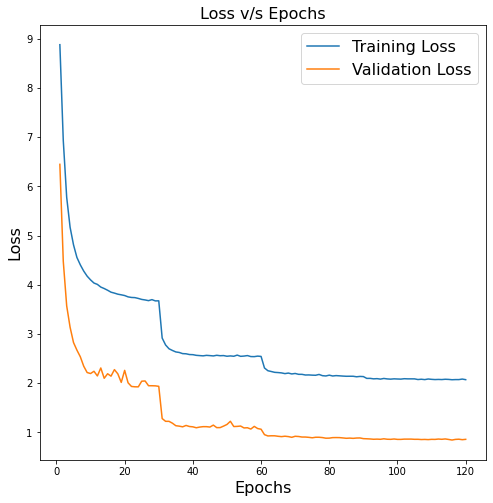

In [23]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, train_loss, label = 'Training Loss')
plt.plot(x, v_loss, label = 'Validation Loss')
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Loss', fontsize =16)
plt.title('Loss v/s Epochs',fontsize =16)
plt.legend(fontsize=16)

Text(0.5, 1.0, 'Validation Accuracy v/s Epochs')

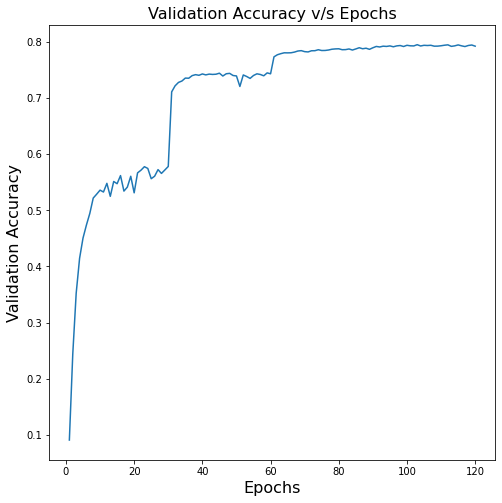

In [24]:
plt.figure(figsize=(8,8))
x = np.arange(1,121)
plt.plot(x, v_acc)
plt.xlabel('Epochs', fontsize =16)
plt.ylabel('Validation Accuracy', fontsize =16)
plt.title('Validation Accuracy v/s Epochs',fontsize =16)


In [19]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 0.6508	Top 1 Training Accuracy: 0.8400	 Top 5 Training Accuracy: 0.9687


In [18]:
v_loss, top1_acc, top5_acc = test_classify(model, validation_dataloader)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\t Top 5 Validation Accuracy: {:.4f}'.format(v_loss, top1_acc, top5_acc))

Validation Loss: 0.8593	Top 1 Validation Accuracy: 0.7930	 Top 5 Validation Accuracy: 0.9484


In [47]:
['ffffe','ffffe','ffffe','fff'].count('fff')

1

In [51]:
'ffffe'[:-1]

'ffff'

In [52]:
min([])

ValueError: min() arg is an empty sequence

In [28]:
from itertools import combinations,permutations

In [130]:
for i in range(len(word)+1):
    s = '.'*(len(word)-i)
#     s='.'
    print(s)
    a = combinations(word+s,4)
    b = b + [''.join(j) for j in a]

....
...
..
.



In [300]:
word ='abcd'
a = permutations('.'*len(word)+'1'*len(word),len(word))
b = set([''.join(j) for j in a])
c = list(b)

for index,w in enumerate (b):
    
    for i in range(len(w)):
        if w[i]=='1':
            w= w[:i] + word[i] + w[(i+1):]
    c[index] = w
            

In [301]:
b

{'....',
 '...1',
 '..1.',
 '..11',
 '.1..',
 '.1.1',
 '.11.',
 '.111',
 '1...',
 '1..1',
 '1.1.',
 '1.11',
 '11..',
 '11.1',
 '111.',
 '1111'}

In [302]:
c

['abcd',
 '....',
 'ab.d',
 'a.c.',
 'a.cd',
 '.b.d',
 'abc.',
 '.bcd',
 'ab..',
 '.bc.',
 '..cd',
 '.b..',
 'a...',
 'a..d',
 '...d',
 '..c.']

In [317]:
word ='bad'
a = permutations('.'*len(word)+word,len(word))
b = set([''.join(j) for j in a])
c = list(b)

# for index,w in enumerate (b):
    
#     for i in range(len(w)):
#         if w[i]=='1':
#             w= w[:i] + word[i] + w[(i+1):]
#     c[index] = w
            

In [44]:
i= permutations('abc...',6)
j = ["".join(j) for j in i]

In [49]:
set(j)

{'...abc',
 '...acb',
 '...bac',
 '...bca',
 '...cab',
 '...cba',
 '..a.bc',
 '..a.cb',
 '..ab.c',
 '..abc.',
 '..ac.b',
 '..acb.',
 '..b.ac',
 '..b.ca',
 '..ba.c',
 '..bac.',
 '..bc.a',
 '..bca.',
 '..c.ab',
 '..c.ba',
 '..ca.b',
 '..cab.',
 '..cb.a',
 '..cba.',
 '.a..bc',
 '.a..cb',
 '.a.b.c',
 '.a.bc.',
 '.a.c.b',
 '.a.cb.',
 '.ab..c',
 '.ab.c.',
 '.abc..',
 '.ac..b',
 '.ac.b.',
 '.acb..',
 '.b..ac',
 '.b..ca',
 '.b.a.c',
 '.b.ac.',
 '.b.c.a',
 '.b.ca.',
 '.ba..c',
 '.ba.c.',
 '.bac..',
 '.bc..a',
 '.bc.a.',
 '.bca..',
 '.c..ab',
 '.c..ba',
 '.c.a.b',
 '.c.ab.',
 '.c.b.a',
 '.c.ba.',
 '.ca..b',
 '.ca.b.',
 '.cab..',
 '.cb..a',
 '.cb.a.',
 '.cba..',
 'a...bc',
 'a...cb',
 'a..b.c',
 'a..bc.',
 'a..c.b',
 'a..cb.',
 'a.b..c',
 'a.b.c.',
 'a.bc..',
 'a.c..b',
 'a.c.b.',
 'a.cb..',
 'ab...c',
 'ab..c.',
 'ab.c..',
 'abc...',
 'ac...b',
 'ac..b.',
 'ac.b..',
 'acb...',
 'b...ac',
 'b...ca',
 'b..a.c',
 'b..ac.',
 'b..c.a',
 'b..ca.',
 'b.a..c',
 'b.a.c.',
 'b.ac..',
 'b.c..a',
 'b.c.a.',

In [72]:
i= permutations('()()()',6)
j = ["".join(j) for j in i]

In [75]:
len(set(j))

20

In [134]:
n=6

In [135]:
a = permutations("()"*n,2*n)
b = list(set(["".join(i) for i in a]))

c=[]

for pattern in b:
    
    score = 0
    
    for i in pattern:
        
        if i == ')':
            score -= 1
        else:
            score += 1
            
        if score < 0:
            break
        
        
    
    if score>=0:
        c.append(pattern)
        
    return c
             
        

SyntaxError: 'return' outside function (<ipython-input-135-e22fae43feb5>, line 25)

In [210]:
ord('A')

65

In [2]:
mkdir 'Fixtures_Data'